In [2]:
import rioxarray
from pyproj import CRS, Proj, Transformer
import dask.array as da
import dask
import numpy as np
import pandas as pd
import pvlib
import rasterio
import geopandas as gpd
import rasterio.mask
import matplotlib.pyplot as plt
from shapely.geometry import mapping

path_tiff = "/home/charriel/Documents/PostdocIGE/Seasonality/Irradiance/ITS_LIVE"
path_dem = f"/home/charriel/Documents/Seasonality/metadata/DEM/Copernicus30m/dem_alps_30m_cropforsolarillu.tif"
path_slope = "/home/charriel/Documents/Seasonality/metadata/DEM/Copernicus30m/slope.tif"
path_aspect = "/home/charriel/Documents/Seasonality/metadata/DEM/Copernicus30m/aspect.tif"

path_save_poa_avg = "/home/charriel/Documents/Seasonality/average_poa_irradiance.tif"
path_save_poa_std = "/home/charriel/Documents/Seasonality/std_poa_irradiance.tif"

In [2]:
# --- 1. Load the Rasters ---
dem = rioxarray.open_rasterio(path_dem)
slope_raster = rioxarray.open_rasterio(path_slope)
aspect_raster = rioxarray.open_rasterio(path_aspect)

altitude = dem.values[0]  # 2D array of elevations
slope_arr = slope_raster.values[0]  # 2D array of slopes (tilt in degrees)
aspect_arr = aspect_raster.values[0]  # 2D array of aspects (surface azimuth in degrees)

# Generate coordinate grids (assuming the DEM has x (longitude) and y (latitude) coordinates)
lon_grid, lat_grid = np.meshgrid(dem.x.values, dem.y.values)

crs_from = dem.rio.crs
crs_to = CRS.from_epsg(4326)  # target CRS
# Create the transformer
transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
lon_grid, lat_grid = transformer.transform(lon_grid, lat_grid)

In [3]:
# --- 2. Define the Time Range ---
times = pd.date_range("2024-01-01 10:30", "2024-12-31 10:30", freq="D", tz="UTC")

# --- 3. Initialize the Output Arrays ---
nrows, ncols = altitude.shape
avg_poa_mean = da.zeros((nrows, ncols), dtype=np.float32)
avg_poa_std = da.zeros((nrows, ncols), dtype=np.float32)


# --- 4. Function to Compute POA for a Single Pixel ---
def compute_poa(i, j):
    pixel_lat = lat_grid[i, j]
    pixel_lon = lon_grid[i, j]
    pixel_alt = altitude[i, j]
    pixel_tilt = slope_arr[i, j]
    pixel_azimuth = aspect_arr[i, j]

    # Create a location object
    loc = pvlib.location.Location(latitude=pixel_lat, longitude=pixel_lon, altitude=pixel_alt)

    # Compute clear-sky irradiance
    clearsky = loc.get_clearsky(times, model='ineichen')

    # Compute solar position
    solpos = loc.get_solarposition(times)

    # Compute POA irradiance
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=pixel_tilt,
        surface_azimuth=pixel_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solpos['apparent_zenith'],
        solar_azimuth=solpos['azimuth']
    )

    # Compute mean and std deviation
    return poa['poa_global'].mean(), poa['poa_global'].std()


# --- 5. Parallel Computation ---
def process_pixel(i, j):
    mean, std = compute_poa(i, j)
    return mean, std


# Create a Dask delayed computation for each pixel
tasks = [[dask.delayed(process_pixel)(i, j) for j in range(ncols)] for i in range(nrows)]

# Convert the list of delayed objects into a Dask array
results = da.compute(*tasks, scheduler='threads')

# Reshape the results into two arrays
poa_means, poa_stds = zip(*[item for row in results for item in row])
avg_poa_mean = np.array(poa_means, dtype=np.float32).reshape(nrows, ncols)
avg_poa_std = np.array(poa_stds, dtype=np.float32).reshape(nrows, ncols)


# --- 6. Save the Results as GeoTIFFs ---
def save_geotiff(filename, data, dem):
    with rasterio.open(
            filename,
            "w",
            driver="GTiff",
            height=data.shape[0],
            width=data.shape[1],
            count=1,
            dtype=data.dtype,
            crs=dem.rio.crs,
            transform=dem.rio.transform(),
    ) as dst:
        dst.write(data, 1)


save_geotiff(path_save_poa_avg, avg_poa_mean, dem)
save_geotiff(path_save_poa_std, avg_poa_std, dem)

print("Parallel computation complete. Results saved.")


Parallel computation complete. Results saved.


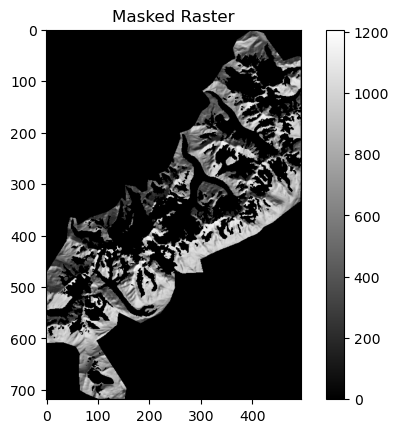

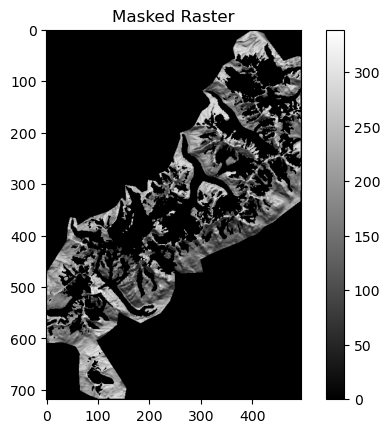

In [25]:
#TO MASK AMPLITUDE ACCORDING TO A NEW SHAPFILE (comment or uncomment)
# Define file paths
shapefile_path = '/home/charriel/Documents/Seasonality/metadata/crop_stable_areas_massif_without_mask_Diego.gpkg'
var_list = ['average', 'std']
for variable in var_list:

    raster_path = f"{path_tiff}/{variable}_poa_irradiance.tif"  #change to x or y
    output_raster_path = f"{path_tiff}/{variable}_poa_irradiance_cropped_massif.tif"  #change to x or y

    # Read the shapefile
    shapefile = gpd.read_file(shapefile_path)
    # Remove empty geometries
    shapefile = shapefile[~shapefile.geometry.is_empty]

    if shapefile.empty:
        raise ValueError("The shapefile contains only empty geometries. Cannot proceed with masking.")

    # Convert geometries to GeoJSON-like format
    geometries = [mapping(geom) for geom in shapefile.geometry]

    # Read the raster file
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, geometries, crop=True)
        out_meta = src.meta.copy()

    # Update metadata
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    # Save the masked raster
    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)

    # Plot the masked raster
    masked_raster = out_image[0]  # Assuming the raster has only one band
    plt.imshow(masked_raster, cmap='gray')
    plt.colorbar()
    plt.title('Masked Raster')
    plt.show()
